### En este caso, proporciona un conjunto de datos en bruto con información de las evaluaciones (fichero compas-scores.csv) y la historia legal de unos 11 000 casos en los años 2013 y 2014 (se trata de uno de los ficheros originales utilizados en un análisis independiente del sistema COMPAS llevado a cabo por ProPublica, disponible en internet).
- “compas_screening_date”: se refiere a la fecha en la que se realizó la evaluación“decile_score”: es un número, de 1 a 10 que indica el riesgo de reincidencia en general (a mayor riesgo, mayor número).
- “v_decile_score”: es un número de 1 a 10, potencialmente distinto del anterior, que indica el riesgo de reincidencia en delitos violentos. Al hacer la evaluación de un caso en COMPAS, se generan las dos puntuaciones (entre otras cosas).
- “is_recid”: indicación de si la persona es reincidente (en el tiempo en que se recogen datos: no hay información de si la persona es reincidente más allá de ciertas fechas, y es importante tener esto en cuenta para asegurarse de hacer comparaciones homogéneas).
- “r_offense_date”: fecha en la que se cometió el delito por el que se considera reincidente a la persona.
- “is_violent_recid”: indicación de si la persona es reincidente en un delito con violencia (las mismas consideraciones sobre fechas que para “is_recid” aplican aquí)".
- “vr_offense_date”: fecha en la que se cometió el delito violento que da lugar a la consideración de reincidente.

1. Cargar los datos y realizar un análisis exploratorio y una evaluación de la calidad de los datos necesarios para el resto del caso.Específicamente, evaluar la integridad, validez y actualidad de los datos y proponer estrategias de mitigación de los posibles problemas encontrados.
2. ¿Son los campos “is_recid” e “is_violent_recid” en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS? Si no es así, definir y calcular una feature que sí lo sea.
3. El umbral para establecer medidas preventivas de la reincidencia es de 7 en adelante. Dado este umbral, generar una tabla de contingencia, explicando qué caso se considera como “positivo” (y, por lo tanto, cuáles son los errores de tipo I y los errores de tipo II).
4. El sistema asigna, de media, evaluaciones de riesgo más altas a los hombres que a las mujeres, y a las personas de raza afroamericana que a las de raza caucásica. Sin embargo, también las tasas de reincidencia son más altas para esos colectivos, aunque no está claro que la asignación de riesgo sea “justa” o no. Mostrar estas diferencias mediante representaciones gráficas y utilizarlas para analizar si la asignación de evaluaciones es justa o no.  
5. ¿Para qué tipo de riesgos, el de delitos generales o el de delitos violentos, tiene el sistema más capacidad predictiva?

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from sklearn.metrics import roc_auc_score

In [2]:
with open('datos\compas-scores.csv', encoding = 'latin1') as f:
    for _ in range(5) : print(f.readline())

id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,num_r_cases,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,is_violent_recid,num_vr_cases,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score,score_text,screening_date

1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,,1,F,Aggravated Assault w/Firearm,0,,,O,,,,,,0,,,,,,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14

2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,0,5,0,0,0,,,,,,,,O,,-1,

In [3]:
# Cargamos los datos del fichero .csv
df = pd.read_csv('datos/compas-scores.csv', encoding = 'latin1', sep = ',')
df.head(5)

id              name    first       last compas_screening_date   sex  \
0   1  miguel hernandez   miguel  hernandez            2013-08-14  Male   
1   2      michael ryan  michael       ryan            2014-12-31  Male   
2   3       kevon dixon    kevon      dixon            2013-01-27  Male   
3   4          ed philo       ed      philo            2013-04-14  Male   
4   5       marcu brown    marcu      brown            2013-01-13  Male   

          dob  age          age_cat              race  ...  vr_offense_date  \
0  1947-04-18   69  Greater than 45             Other  ...              NaN   
1  1985-02-06   31          25 - 45         Caucasian  ...              NaN   
2  1982-01-22   34          25 - 45  African-American  ...       2013-07-05   
3  1991-05-14   24     Less than 25  African-American  ...              NaN   
4  1993-01-21   23     Less than 25  African-American  ...              NaN   

                vr_charge_desc  v_type_of_assessment  v_decile_score  \
0                          NaN      Risk of Violence               1   
1                          NaN      Risk of Violence               2   
2  Felony Battery (Dom Strang)      Risk of Violence               1   
3                          NaN      Risk of Violence               3   
4                          NaN      Risk of Violence               6   

   v_score_text  v_screening_date  type_of_assessment decile_score.1  \
0           Low        2013-08-14  Risk of Recidivism              1   
1           Low        2014-12-31  Risk of Recidivism              5   
2           Low        2013-01-27  Risk of Recidivism              3   
3           Low        2013-04-14  Risk of Recidivism              4   
4        Medium        2013-01-13  Risk of Recidivism              8   

  score_text screening_date  
0        Low     2013-08-14  
1     Medium     2014-12-31  
2        Low     2013-01-27  
3        Low     2013-04-14  
4       High     2013-01-13  

[5 rows x 47 columns]

In [4]:
df.shape

(11757, 47)

## 1. Cargar los datos y realizar un análisis exploratorio y una evaluación de la calidad de los datos necesarios para el resto del caso.Específicamente, evaluar la integridad, validez y actualidad de los datos y proponer estrategias de mitigación de los posibles problemas encontrados.

<AxesSubplot:>

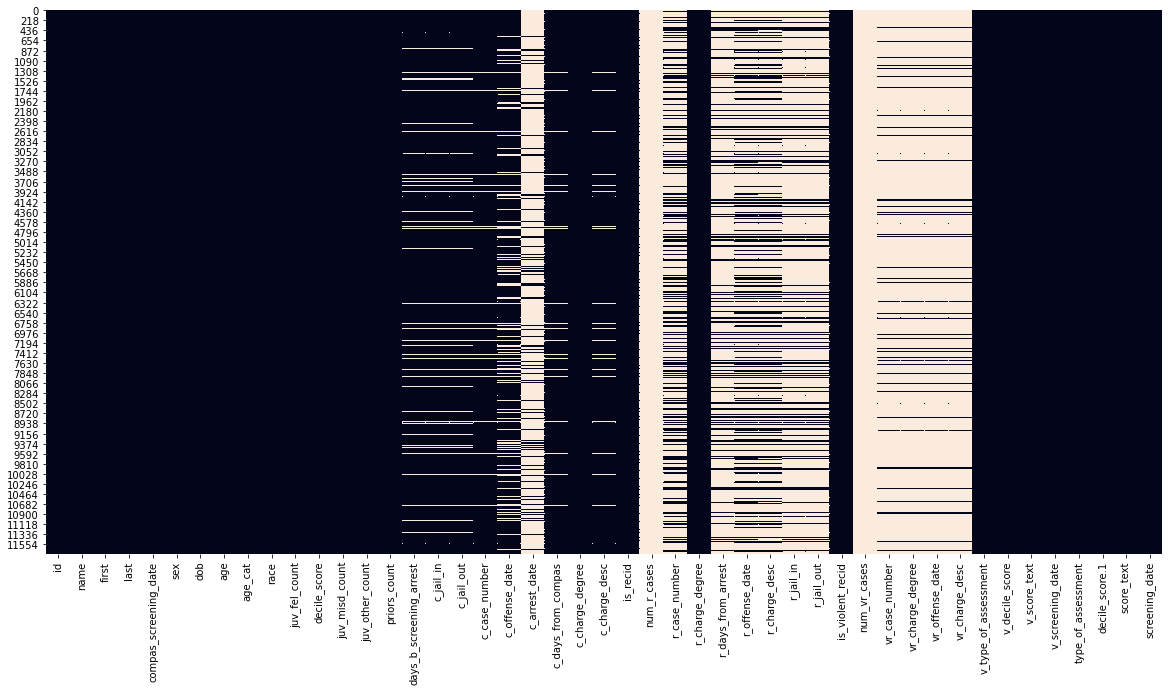

In [5]:
# 1.1 La integridad se refiere al hecho de disponer de todos los datos relevantes para el uso que se quiera hacer de
#ellos.Vizualizamos los datos faltantes: las columnas num_vr_cases y num_vr_cases no tienen valores.
#Las podemos eliminar de nuestro dataset.
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)

In [6]:
# 1.2 Validez de los datos:La validez de los datos hace referencia a que estos sigan las reglas 
# y la sintaxis definidas para ellos.
df.dtypes #object-> string

id                           int64
name                        object
first                       object
last                        object
compas_screening_date       object
sex                         object
dob                         object
age                          int64
age_cat                     object
race                        object
juv_fel_count                int64
decile_score                 int64
juv_misd_count               int64
juv_other_count              int64
priors_count                 int64
days_b_screening_arrest    float64
c_jail_in                   object
c_jail_out                  object
c_case_number               object
c_offense_date              object
c_arrest_date               object
c_days_from_compas         float64
c_charge_degree             object
c_charge_desc               object
is_recid                     int64
num_r_cases                float64
r_case_number               object
r_charge_degree             object
r_days_from_arrest  

In [7]:
#Transformamos las columnas que tienen una fecha a un datetime64
columnas = ['c_offense_date','dob','c_arrest_date','c_jail_in','v_screening_date','r_offense_date','r_jail_in','r_jail_out','c_jail_out','vr_offense_date','compas_screening_date','screening_date']
for i in columnas:
    df[i]= pd.to_datetime(df[i])

In [8]:
#Cambiamos las columnas con pocos valores posibles a tipo categórico
columnas_cat = df.select_dtypes(include = 'object')
for field in columnas_cat:
    df[field] = df[field].astype('category')

In [9]:
df.dtypes

id                                  int64
name                             category
first                            category
last                             category
compas_screening_date      datetime64[ns]
sex                              category
dob                        datetime64[ns]
age                                 int64
age_cat                          category
race                             category
juv_fel_count                       int64
decile_score                        int64
juv_misd_count                      int64
juv_other_count                     int64
priors_count                        int64
days_b_screening_arrest           float64
c_jail_in                  datetime64[ns]
c_jail_out                 datetime64[ns]
c_case_number                    category
c_offense_date             datetime64[ns]
c_arrest_date              datetime64[ns]
c_days_from_compas                float64
c_charge_degree                  category
c_charge_desc                    c

In [10]:
#Vemos que las columnas v_screening_date-compas_screening_date-screening_date son idénticas
a =  (df['v_screening_date'] - df['compas_screening_date']).dt.days
b = (df['v_screening_date']-df['screening_date']).dt.days
print("v_screening_date - compas_screening_date =" ,a.sum())
print("v_screening_date - screening_date =" ,b.sum())
print("Eliminamos las columnas v_screening_date y compas_screening_date.")

v_screening_date - compas_screening_date = 0
v_screening_date - screening_date = 0
Eliminamos las columnas v_screening_date y compas_screening_date.


In [11]:
df.drop(['v_screening_date','compas_screening_date','num_r_cases','num_vr_cases'],axis=1,inplace=True)

In [12]:
# 1.3 Actualidad de los datos: distinguir la fecha a la que hace referencia un dato de la fecha en la que se conocía 
# ese dato.En nuestro caso, todos los casos con is_recid tienen fecha de reincidencia:
len(df[df.is_recid==1][pd.isnull(df.r_offense_date)])

<ipython-input-12-d22f2998b40c>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[df.is_recid==1][pd.isnull(df.r_offense_date)])


0

In [13]:
#Pero los datos terminan en una cierta fecha:
df.r_offense_date.max()

Timestamp('2016-03-29 00:00:00')

In [14]:
# Es probable que para los casos más recientes haya menos reincidencia.
#Podemos comprobar esto calculando el porcentaje de reincidencia para las evaluaciones de cada trimestre.
df['quarter'] = pd.PeriodIndex(df.screening_date, freq='Q')
pd.crosstab(df['quarter'],df['is_recid']).apply(lambda r: r/r.sum(), axis=1).style.format("{:.1%}")

In [15]:
# definimos una variable de 2 años y otra de 0 días.
import datetime
d=datetime.timedelta(days=730)
e=datetime.timedelta(days=0)

In [16]:
# última fecha en la que se cometió el delito por el que se considera reincidente a la persona: abril/2016
from datetime import date
dateFin = date(2016, 4, 1)
dateFin

datetime.date(2016, 4, 1)

Para tener un dataset homogéneo, vamos a trabajar con las personas que han cometido un crimen en los dos últimos años, o que llevan al menos dos años fuera de la carcel. El número de días entre el día de salida de la cárcel y la fecha de reincidencia no debería ser positivo. Por ejemplo, "Romalice Poitier" estuvo en la carcel del 26/06/2013 al 22/08/2013 y repitió un crimen el 26/06/2013. No parece un dato correcto.

In [17]:
df['test']=df['c_jail_out']-df['r_offense_date']
df2=df[df.test>e]#superieur a 0 dias.
df2[['id','name','c_jail_in','c_jail_out','c_offense_date','r_offense_date','test']]

id               name           c_jail_in          c_jail_out  \
12        13          bo bradac 2015-01-06 03:55:34 2015-01-07 03:38:44   
19        20    samuel seraphin 2014-06-25 02:15:57 2014-06-28 05:02:21   
74        75     elliott knauff 2014-02-28 11:19:21 2014-03-11 02:46:41   
159      160         jimmy bell 2015-05-31 07:39:18 2015-09-18 01:21:56   
174      175   anthony sanmarco 2013-03-16 03:53:03 2013-03-17 01:43:20   
...      ...                ...                 ...                 ...   
11241  11242   romalice poitier 2013-06-26 11:42:09 2013-08-22 11:38:00   
11253  11254   joseph magliocca 2013-07-05 07:09:41 2013-08-21 10:58:38   
11271  11272      michael moore 2014-12-16 07:14:10 2015-04-28 06:35:54   
11310  11311       katelyn dest 2013-08-20 10:16:41 2013-08-21 04:10:12   
11535  11536  grantley nicholls 2013-04-08 04:58:19 2013-04-09 04:32:39   

      c_offense_date r_offense_date              test  
12        2012-12-31     2015-01-06   1 days 03:38:44  
19        2014-03-24     2014-06-25   3 days 05:02:21  
74               NaT     2014-02-01  38 days 02:46:41  
159              NaT     2015-05-31 110 days 01:21:56  
174       2013-03-15     2013-03-17   0 days 01:43:20  
...              ...            ...               ...  
11241     2013-05-21     2013-06-26  57 days 11:38:00  
11253     2012-12-18     2013-03-14 160 days 10:58:38  
11271     2014-12-16     2015-01-12 106 days 06:35:54  
11310     2013-06-27     2013-08-20   1 days 04:10:12  
11535     2013-03-12     2013-04-08   1 days 04:32:39  

[237 rows x 7 columns]

In [18]:
# agrupamos las columnas c_offense_date y c_arrest_date para tener la fecha de la primera detención.
df['fecha_primer_arrest']=df['c_offense_date'].fillna(df['c_arrest_date'])
df['fecha_primer_arrest']

0       2013-08-13
1              NaT
2       2013-01-26
3       2013-04-13
4       2013-01-12
           ...    
11752   2013-09-21
11753   2013-05-16
11754   2014-10-07
11755   2013-05-21
11756   2014-01-10
Name: fecha_primer_arrest, Length: 11757, dtype: datetime64[ns]

Definimos una función donde: 
1. _Por los casos de reincidencia_: La fecha de reincidencia es <= a dos años y la fecha de salida de la carcel > a la fecha de reincidencia 
2. _En caso de no-reincidencia_: la fecha de la primera detencion + dos años es < a la última fecha: 01/04/2016 del dataset.

In [19]:
def my_func (x,var1,var2,var3,var4,var5):
    if (x[var1]-x[var3]<=d and x[var2]==1 and x[var4]-x[var1]<e ) or (x[var3]+d < dateFin and x[var2]==0 ) :
        x[var5]=x[var1]-x[var3]
    else:
        x[var5]=0
    return x[var5]


In [20]:
# Definimos una variable diferencia con el valor arbitrario 20
df['dif'] = np.random.randint(20, 21, df.shape[0])

In [21]:
df['dif']=df.apply(lambda x: my_func(x,'r_offense_date','is_recid','fecha_primer_arrest','c_jail_out','dif'), axis=1)

In [22]:
#definimos un nuevo dataframe con estos criterios.
df1=df[df['dif']!=0]
df1.shape

(7903, 47)

Para obtener datos de calidad, consideramos que si la variable "days_b_screening_arrest" (número de días entre las evaluaciones y la detención) no está en un rango de 30 días, no se puede tener en cuenta.
Descartamos tambien las detenciones por tráfico, si la variable "is_recid" es -1 es decir, si no encontramos ningún caso Compas y por último, descartamos las filas sin score_text.

In [23]:

df1 = df1[
    (df1.days_b_screening_arrest <= 30) &  
    (df1.days_b_screening_arrest >= -30) &
     (df1.c_charge_degree!="O") &
     (df1.is_recid!=-1) &
     (df1.decile_score!=-1) &
     (df1.score_text != 'N/A')]

In [24]:
df1.shape

(6742, 47)

In [25]:
df1.describe()

id          age  juv_fel_count  decile_score  juv_misd_count  \
count   6742.000000  6742.000000    6742.000000   6742.000000     6742.000000   
mean    5886.157520    34.586473       0.065411      4.486651        0.090033   
std     3401.804286    11.720203       0.491457      2.869932        0.511890   
min        1.000000    18.000000       0.000000      1.000000        0.000000   
25%     2930.250000    25.000000       0.000000      2.000000        0.000000   
50%     5876.500000    31.000000       0.000000      4.000000        0.000000   
75%     8820.750000    42.000000       0.000000      7.000000        0.000000   
max    11757.000000    96.000000      20.000000     10.000000       13.000000   

       juv_other_count  priors_count  days_b_screening_arrest  \
count      6742.000000   6742.000000              6742.000000   
mean          0.107535      3.285227                -1.843073   
std           0.475640      4.797649                 4.965419   
min           0.000000      0.000000               -30.000000   
25%           0.000000      0.000000                -1.000000   
50%           0.000000      1.000000                -1.000000   
75%           0.000000      4.000000                -1.000000   
max           9.000000     38.000000                30.000000   

       c_days_from_compas     is_recid  r_days_from_arrest  is_violent_recid  \
count         6742.000000  6742.000000         1943.000000       6742.000000   
mean            27.791753     0.423317           20.170355          0.098190   
std            276.820998     0.494121           74.817652          0.297594   
min              0.000000     0.000000           -1.000000          0.000000   
25%              1.000000     0.000000            0.000000          0.000000   
50%              1.000000     0.000000            0.000000          0.000000   
75%              1.000000     1.000000            1.000000          0.000000   
max           9485.000000     1.000000          993.000000          1.000000   

       v_decile_score  decile_score.1                           test  
count     6742.000000     6742.000000                           2854  
mean         3.683477        4.486651  -229 days +03:31:18.134547992  
std          2.515831        2.869932    186 days 03:45:55.057663172  
min          1.000000        1.000000            -731 days +01:34:19  
25%          1.000000        2.000000     -354 days +13:09:44.250000  
50%          3.000000        4.000000            -182 days +09:26:06  
75%          5.000000        7.000000      -72 days +03:41:23.250000  
max         10.000000       10.000000              -1 days +11:23:49

## 2. ¿Son los campos “is_recid” e “is_violent_recid” en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS? Si no es así, definir y calcular una feature que sí lo sea.

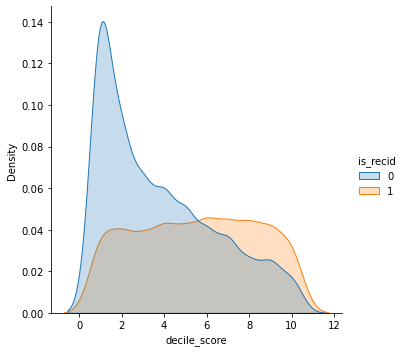

In [26]:
#“decile_score”: es un número, de 1 a 10 que indica el riesgo de reincidencia en general (a mayor riesgo, mayor número).
#Comparamos visualmente la nota con el hecho de haber repetido un crimen que sea violento o no:
sns.displot(df1, x="decile_score", hue="is_recid", kind="kde", fill=True)

In [27]:
df1.drop(['dif','test','quarter'],axis=1,inplace=True)

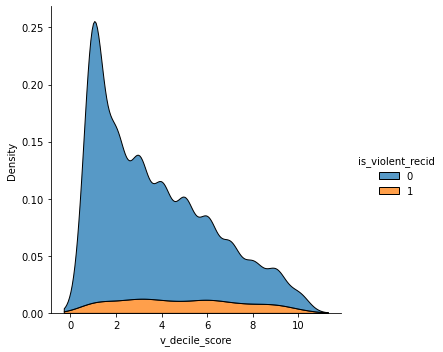

In [28]:
sns.displot(df1, x="v_decile_score", hue="is_violent_recid", kind="kde", multiple="stack")

Podemos intentar definir una feature que sea más precisa para evaluar las estimaciones de riesgo. 
Para ello, analizamos diferentes variables. Por ejemplo, se realizan unos boxplot para ver la distribución de valores de las variables continuas para el decile_score obtenido en el caso de reincidencia.Destacamos que los más jovenes, que tienen más delitos previos, son más susceptibles de reincidir y de ser caracterizados con un riesgo alto.

In [31]:
columnas_num = ['age', 'priors_count']
df1_1 = df1[df1["is_recid"] == 1]
columnas_cat = ['age_cat','race','sex','c_charge_degree','r_charge_degree']

In [32]:
import altair as alt
alt.Chart(df1_1).mark_boxplot().encode(y = alt.X('decile_score:N', title = None), 
                                       x = alt.Y(alt.repeat("row"), type='quantitative'),
                                       color = alt.Color('decile_score:N', legend = None))\
                                       .repeat(row=columnas_num)\
                                       .resolve_scale(x = 'independent')

alt.RepeatChart(...)

<AxesSubplot:xlabel='age', ylabel='Count'>

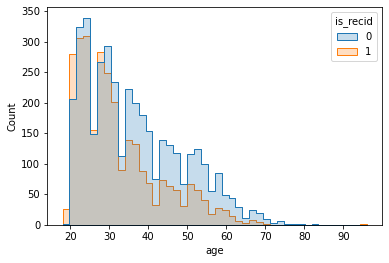

In [33]:
# También lo podemos visualizar haciendo una superposición de las variables.
sns.histplot(data=df1,x="age",hue="is_recid",element="step")

Para la variables categóricas, analizamos si hay variables con capacidad predictiva. Podemos ver que la proporción de reincidencias es más elevada para los varones que tienen menos de 25 años,de raza africanos-americanos, y cuyo crimen  original era de tipo "F".

In [34]:
def get_data_chunk(field):
    return df1_1.groupby(field)['score_text'].apply(lambda x: (x == 'High').mean())\
                   .rename('Porcentaje riesgo elevado')\
                   .reset_index()\
                   .rename(columns = {field : 'value'})\
                   .assign(var = field)

riesgo_alto_por_valor = pd.concat([get_data_chunk(field) 
                                   for field in columnas_cat])

alt.Chart(riesgo_alto_por_valor, title = 'Porcentaje riesgo elevado').mark_bar()\
                        .encode( x = 'Porcentaje riesgo elevado:Q', y = alt.Y('value:N', title = None), row = 'var:N')\
                        .resolve_scale(y = 'independent')

alt.Chart(...)

In [35]:
# la variable r_charge_degree aparece en un 100 por 100 para el valor "O", pero vemos que representa muy pocas personas (1).
alt.Chart(df1_1).mark_bar().encode(x = alt.X('score_text:N', title = None), 
                                         y = 'count(r_charge_degree):Q', 
                                         color = alt.Color('score_text:N', legend = None),
                                         column = 'r_charge_degree:O')

alt.Chart(...)

<AxesSubplot:>

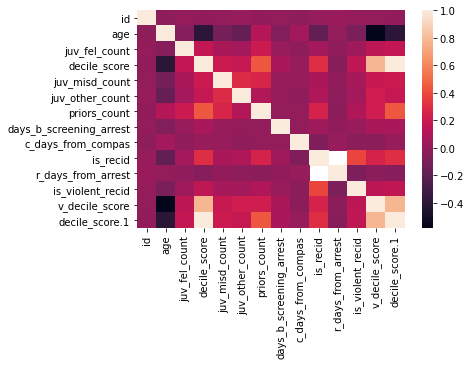

In [36]:
# Podemos ver una matriz de correlación que nos ayuda a entender la correlación entre las distintas variables.
sns.heatmap(df1.corr())

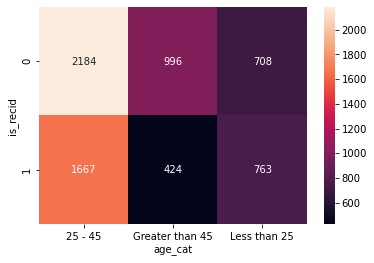

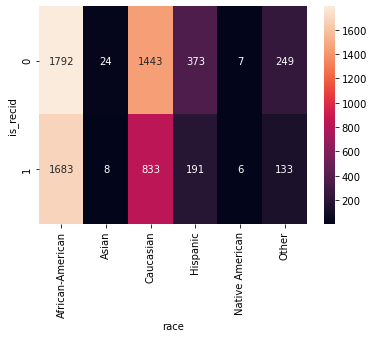

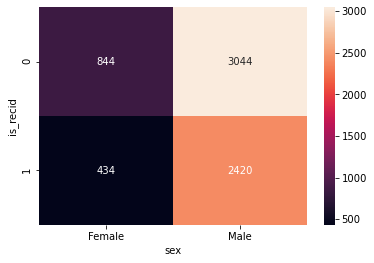

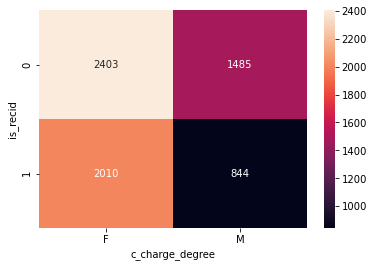

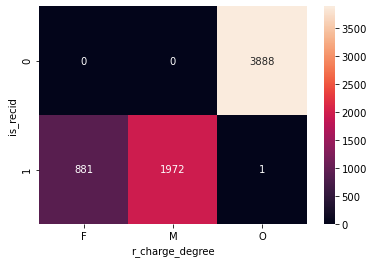

In [37]:
# Una forma muy útil de ver la relación entre la reincidencia y las distintas variables 
# es con una vizualización de una crosstab
for col in columnas_cat:
    plt.figure()
    sns.heatmap(pd.crosstab(df1['is_recid'],df1[col]),annot=True,fmt='d')

#### Podemos utilizar estas características para intentar definir si una persona va a reincidir o no.

In [38]:
def modelo(caso):
    if caso['age_cat'] == '25-45'\
    or caso['race'] == 'African-American'\
    or caso['priors_count'] >= 5:
        return 1
    else:
        return 0

In [39]:
score = df1.apply(lambda x: modelo(x), axis = 1)

In [40]:
dg_feature=roc_auc_score((df1['is_recid'] == 1), score)
print("Capacidad predictiva del feature : %.2f" % dg_feature)

Capacidad predictiva del feature : 0.59


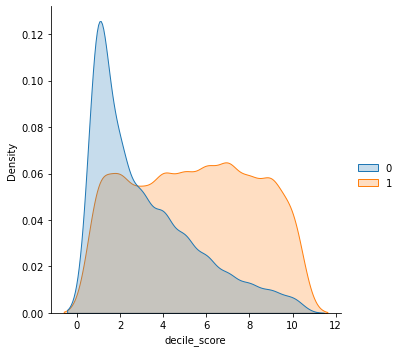

In [41]:
# Visualmente nuestra feature tiene más poder de predicción que la variable "decile_score".
sns.displot(df1, x="decile_score", hue=score, kind="kde", fill=True)

## 3. El umbral para establecer medidas preventivas de la reincidencia es de 7 en adelante. Dado este umbral, generar una tabla de contingencia, explicando qué caso se considera como “positivo” (y, por lo tanto, cuáles son los errores de tipo I y los errores de tipo II).

In [42]:
df1['guessed_recid'] = df1['decile_score'] >= 7
df1['actual_recid'] = df1.is_recid == 1
tabla_contingencia = pd.crosstab(df1.actual_recid, df1.guessed_recid)
tabla_contingencia 

guessed_recid  False  True 
actual_recid               
False           3165    723
True            1715   1139

<AxesSubplot:xlabel='actual_recid'>

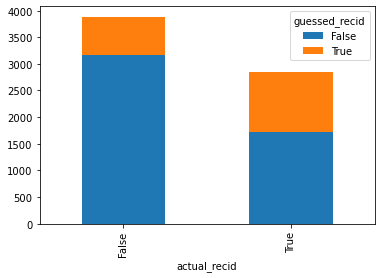

In [43]:
pd.crosstab(df1.actual_recid, df1.guessed_recid).plot(kind='bar',stacked=True)

In [44]:
def t(VN, FP, FN, VP):
    Tot_Negativo = VN + FP
    Tot_positivo = VP + FN
    total_casos=Tot_Negativo + Tot_positivo
    especificidad = VN/(VN+FP)
    sensibilidad = VP/(VP+FN)
    precision = VP/(VP+FP)
    exactitud= (VP+VN )/total_casos
    fScore=2*(precision*sensibilidad)/(precision+sensibilidad)
    print("Nº total de casos: %.2f" % (total_casos))
    print("Tasa falso positivo: %.2f" % (FP / Tot_Negativo * 100))
    print("Tasa falso negativo: %.2f" % (FN / Tot_positivo * 100))
    print("Especificidad: %.2f" % especificidad)
    print("Sensibilidad: %.2f" % sensibilidad)
    print("Exactitud: %.2f" % exactitud)
    print("FScore: %.2f" % fScore)
    print("Precision: %.2f" % precision)

In [45]:
## real - - predicion
VN = tabla_contingencia[False][False]
VP = tabla_contingencia[True][True]
FN = tabla_contingencia[True][False]
FP = tabla_contingencia[False][True]
t(VN, FP, FN, VP)

Nº total de casos: 6742.00
Tasa falso positivo: 35.14
Tasa falso negativo: 38.83
Especificidad: 0.65
Sensibilidad: 0.61
Exactitud: 0.64
FScore: 0.48
Precision: 0.40


## 4. El sistema asigna, de media, evaluaciones de riesgo más altas a los hombres que a las mujeres, y a las personas de raza afroamericana que a las de raza caucásica. Sin embargo, también las tasas de reincidencia son más altas para esos colectivos, aunque no está claro que la asignación de riesgo sea “justa” o no. Mostrar estas diferencias mediante representaciones gráficas y utilizarlas para analizar si la asignación de evaluaciones es justa o no.

In [46]:
# % del total
100 * df1['race'].value_counts() / len(df1['race'])
#Para una mejor representación gráfica vamos a trabajar con las razas: 'African-American', 'Caucasian' e 'Hispanic' 
# 93.66% del dataFrame.

African-American    51.542569
Caucasian           33.758529
Hispanic             8.365470
Other                5.665974
Asian                0.474637
Native American      0.192821
Name: race, dtype: float64

In [47]:
df2=df1[df1.race.isin(['African-American', 'Caucasian', 'Hispanic'])]
df2.race.unique()

['African-American', 'Caucasian', 'Hispanic']
Categories (3, object): ['African-American', 'Caucasian', 'Hispanic']

In [48]:
#Ordenamos los campos
rangos_edad = pd.CategoricalDtype(['Less than 25', '25 - 45', 'Greater than 45'],ordered=True)
df2['age_cat'] = df2['age_cat'].astype(rangos_edad)
rangos_score_text = pd.CategoricalDtype(['Low', 'Medium', 'High'],ordered=True)
df2['score_text'] = df2['score_text'].astype(rangos_score_text)
df2['v_score_text'] = df2['v_score_text'].astype(rangos_score_text)
df2.race=df2.race.astype('object')

<ipython-input-48-03f32e3de88a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['age_cat'] = df2['age_cat'].astype(rangos_edad)
<ipython-input-48-03f32e3de88a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['score_text'] = df2['score_text'].astype(rangos_score_text)
<ipython-input-48-03f32e3de88a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

<AxesSubplot:title={'center':'Riesgo probable de reincidencia Hombre-Mujer'}, xlabel='sex'>

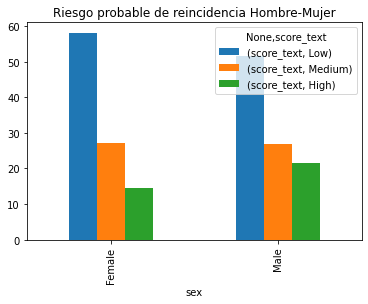

In [49]:
#Comparación de las evaluaciones de riesgo hombres - mujeres:
sumaScore=df2.groupby(['sex', 'score_text']).agg({'score_text': 'count'})
porcentajeScore_text = sumaScore.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
porcentajeScore_text.unstack().plot.bar(stacked=False,title='Riesgo probable de reincidencia Hombre-Mujer')

In [50]:
#Comparación de las evaluaciones de riesgo de razas:
data = df2.groupby(['score_text', 'race'])['name'].count().reset_index()
alt.Chart(data, width=250, height=150, title='Riesgo probable de reincidencia por razas').mark_bar().encode(
    x = alt.X('score_text:O', sort = rangos_edad.categories.to_list(), title = None),
    y = alt.Y('name:Q', title = 'Numero de implicados'),
    facet=alt.Facet('race:N', title = None))

alt.Chart(...)

In [51]:
sumaScore=df2.groupby(['race', 'score_text']).agg({'score_text': 'count'})
porcentajeScore_text = sumaScore.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
porcentajeScore_text

score_text
race             score_text            
African-American Low          40.719424
                 Medium       31.136691
                 High         28.143885
Caucasian        Low          66.476274
                 Medium       22.715290
                 High         10.808436
Hispanic         Low          71.631206
                 Medium       19.148936
                 High          9.219858

<AxesSubplot:xlabel='race'>

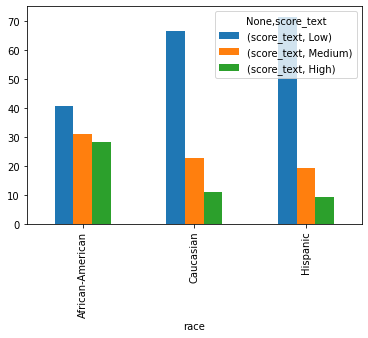

In [52]:
#Representación en porcentaje:
porcentajeScore_text.unstack().plot.bar(stacked=False)

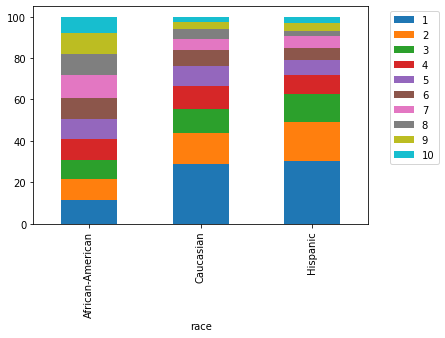

In [53]:
# También lo podemos vizualizar con la asignación de la variable "decile_score"
pd.crosstab(df2['race'],df2['decile_score']).apply(lambda r:100* r/r.sum(), axis=1).plot(kind='bar', stacked=True)                    
plt.legend(bbox_to_anchor=(1.05, 1))

In [54]:
#tasas de reincidencia por raza:

In [55]:
pd.crosstab(df2['race'],df2['is_recid']).apply(lambda r:100* r/r.sum(), axis=1)

is_recid                  0          1
race                                  
African-American  51.568345  48.431655
Caucasian         63.400703  36.599297
Hispanic          66.134752  33.865248

## 5. ¿Para qué tipo de riesgos, el de delitos generales o el de delitos violentos, tiene el sistema más capacidad predictiva?

In [56]:
# Podemos comprobar el poder predictivo calculando el AUC ROC de los delitos generales:
dg= roc_auc_score((df1['score_text'] =='High'), df1.is_recid)
dv= roc_auc_score((df1['v_score_text'] =='High'), df1.is_violent_recid)
print("Capacidad predictiva de los delitos generales : %.2f" % dg)
print("Capacidad predictiva de los delitos violentos: %.2f" % dv)

Capacidad predictiva de los delitos generales : 0.63
Capacidad predictiva de los delitos violentos: 0.55


In [57]:
# En el caso del modelo que hicimos previamente, como el resultado es binario, podemos hacer una tabla de contingencia 
#y calcular su coste:
tc_2 = pd.crosstab(score, df2['is_recid'])
tc_2

is_recid     0     1
row_0               
0         1631   760
1         1977  1947

In [58]:
#coste de los errores cometidos por los modelos:
#coste: donde FP=FN=-1  y VP=VN=0.
coste = pd.DataFrame([[0, -1], [-1, 0]], columns=tc_2.columns, index=tc_2.index)
coste

is_recid  0  1
row_0         
0         0 -1
1        -1  0

In [59]:
# El coste de usar el modelo sería:
(tc_2 * coste).sum().sum()

-2737